In [23]:
# read cities.txt (id, lat, lon) and plot every city on a map
import matplotlib.pyplot as plt
import numpy as np
import sys
from math import radians, cos, sin, sqrt, atan2

In [24]:
def read_cities(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
    cities = []
    for line in lines:
        id, lat, lon, pop = line.split()
        cities.append((id, float(lat), float(lon), int(pop)))
    print(f"Read {len(cities)} cities from {filename}")
    return cities

def remove_outliers(cities):
    lats = [lat for id, lat, lon, pop in cities]
    lons = [lon for id, lat, lon, pop in cities]
    lat_mean = np.mean(lats)
    lat_std = np.std(lats)
    lon_mean = np.mean(lons)
    lon_std = np.std(lons)
    cities = [(id, lat, lon, pop) for id, lat, lon, pop in cities if abs(lat - lat_mean) < 3 * lat_std and abs(lon - lon_mean) < 3 * lon_std]
    return cities

def map_range(x, in_min, in_max, out_min, out_max):
  return (x - in_min) * (out_max - out_min) // (in_max - in_min) + out_min

def plot_cities(cities):
    plt.figure(figsize=(12, 8))  # Reduced the figure size for practicality
    lats = [lat for id, lat, lon, pop in cities]
    lons = [lon for id, lat, lon, pop in cities]
    pops = [pop for id, lat, lon, pop in cities]
    # Normalize population values for markersize if needed
    min_pop = min(pops)
    max_pop = max(pops)
    norm_pops = [map_range(pop, min_pop, max_pop, 1, 100) for pop in pops]
    plt.scatter(lons, lats, s=norm_pops, c="red")  # Using scatter for variable markersize
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("City Plot")
    plt.show()

Read 1000 cities from cities.txt


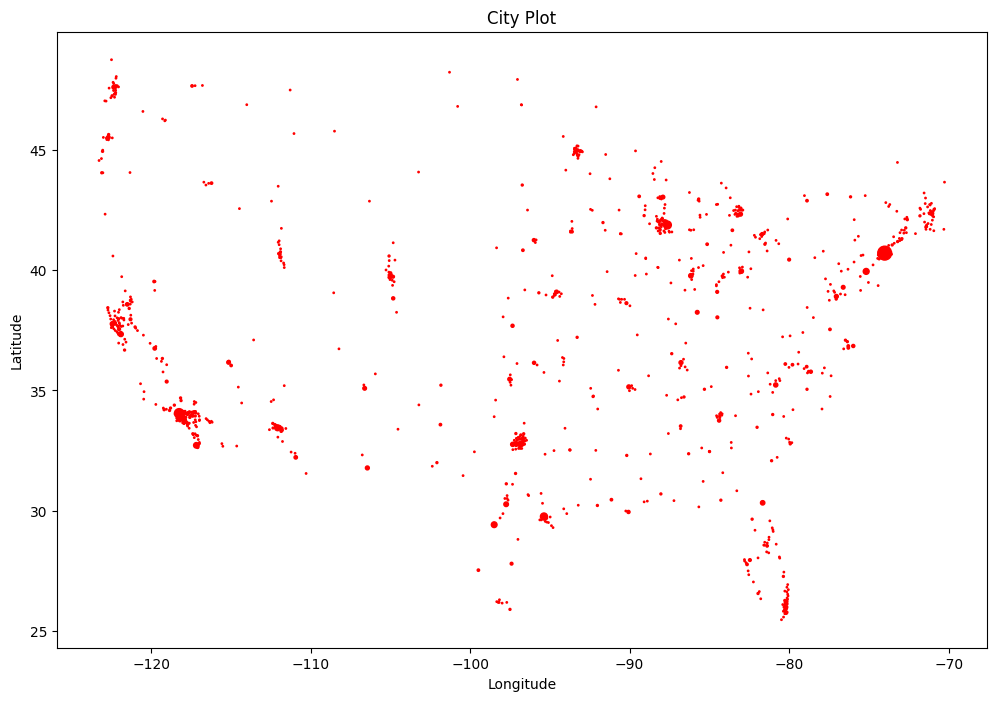

In [25]:
cities = read_cities("cities.txt")
cities = remove_outliers(cities)
plot_cities(cities)

In [36]:
def calculate_redundancy_score_1(cities):
    redundancy_scores = []
    for i, (id1, lat1, lon1, pop1) in enumerate(cities):
        score = 0
        for j, (id2, lat2, lon2, pop2) in enumerate(cities):
            if i != j:
                distance = np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)
                score += pop2 / distance
        redundancy_scores.append((id1, 1 / score))
    return redundancy_scores

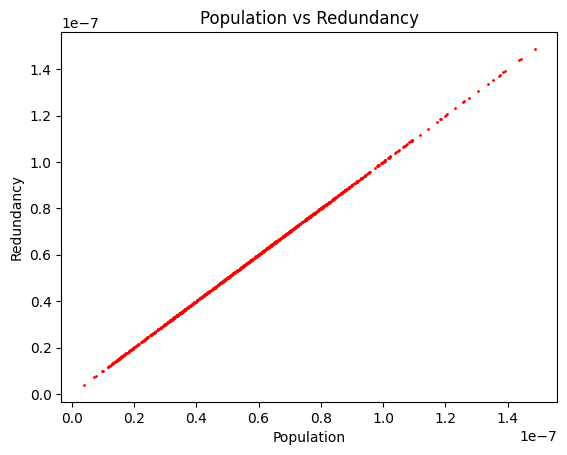

In [37]:
# keep the 100 most redundant cities
scores = calculate_redundancy_score_1(cities)
# plot graph between redundancy and population
pops = [pop for id, pop in scores]
redundancies = [score for id, score in scores]
plt.scatter(pops, redundancies, c="red", s=1)
plt.xlabel("Population")
plt.ylabel("Redundancy")
plt.title("Population vs Redundancy")
plt.show()

In [ ]:
# plot red